<a href="https://colab.research.google.com/github/TacubaSalva0206/Servicio-social-exoplanetas/blob/main/Versi%C3%B3n_b_redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER (Redes Neuronales con SHAP)
Librerías cargadas exitosamente.

CARGA Y EXPLORACIÓN DE DATOS
Dimensiones: 9,564 filas × 50 columnas

LIMPIEZA Y PREPARACIÓN DE DATOS
Dataset final: 36 características, 9,564 muestras

Distribución de Clases:
--------------------------------------------------
FALSE POSITIVE: 5,023 (52.52%)
CONFIRMED: 2,293 (23.98%)
CANDIDATE: 2,248 (23.50%)


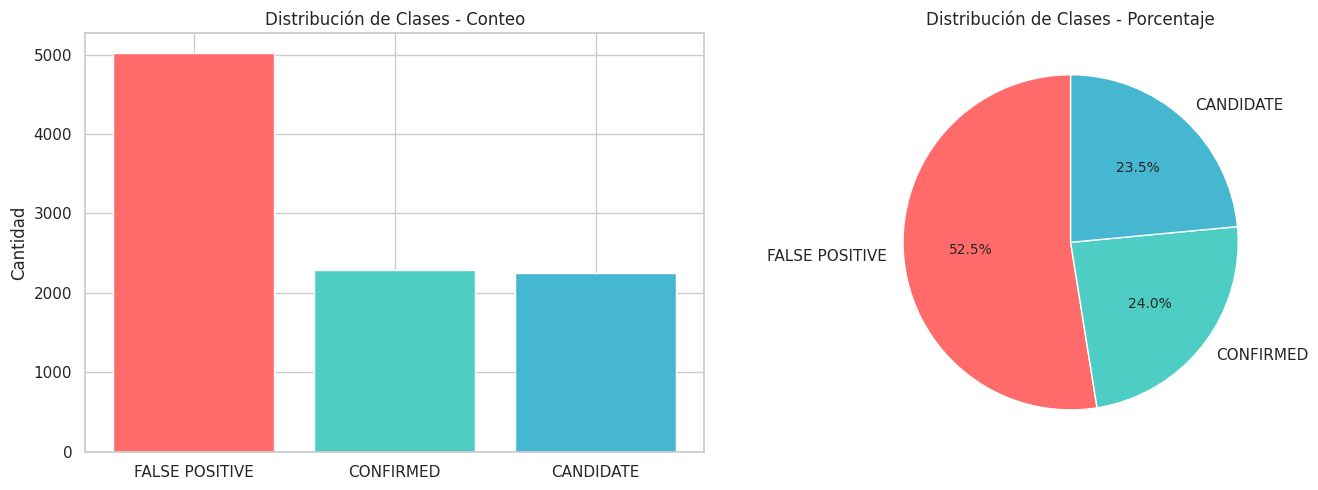


PIPELINE DE PREPROCESAMIENTO
Características seleccionadas: ['koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_prad'] ...

DEFINICIÓN DE MODELOS - REDES NEURONALES

EVALUACIÓN COMPARATIVA - REDES NEURONALES

Entrenando: Red Neuronal (Normal)

Entrenando: Red Neuronal (Regularizada)

Resultados comparativos:
                     Modelo  CV Accuracy  Test Accuracy  F1-Score
      Red Neuronal (Normal)       0.7250         0.7348    0.7163
Red Neuronal (Regularizada)       0.7151         0.7321    0.7082

INTERPRETABILIDAD CON SHAP - MEJOR RED NEURONAL


  0%|          | 0/200 [00:00<?, ?it/s]

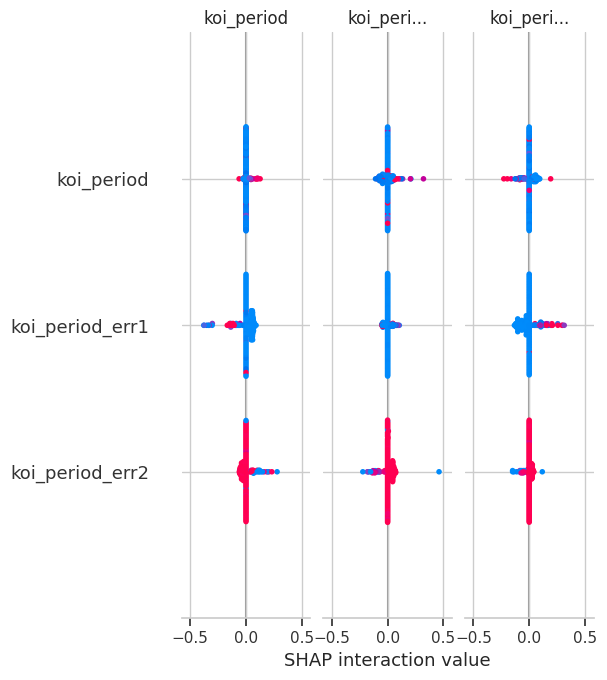


MATRICES DE CONFUSIÓN - REDES NEURONALES


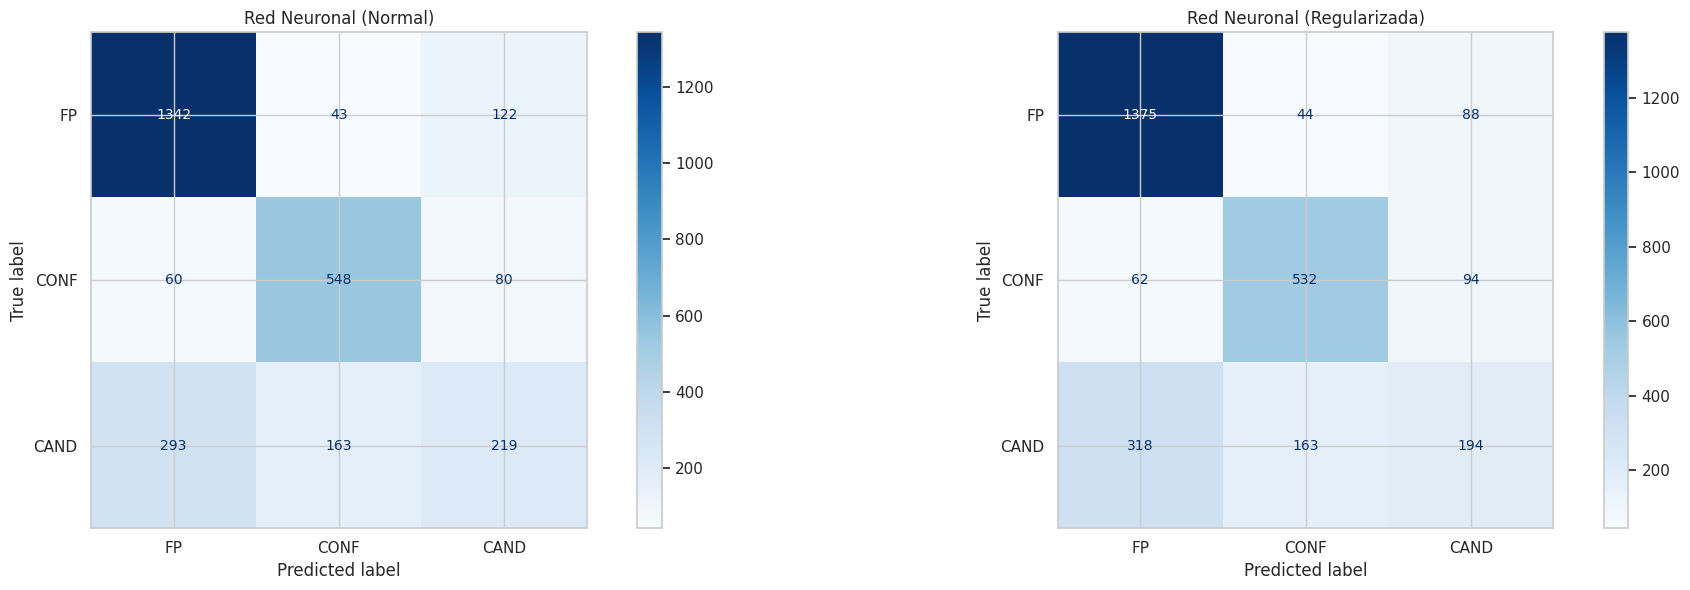


CURVAS DE APRENDIZAJE - REDES NEURONALES


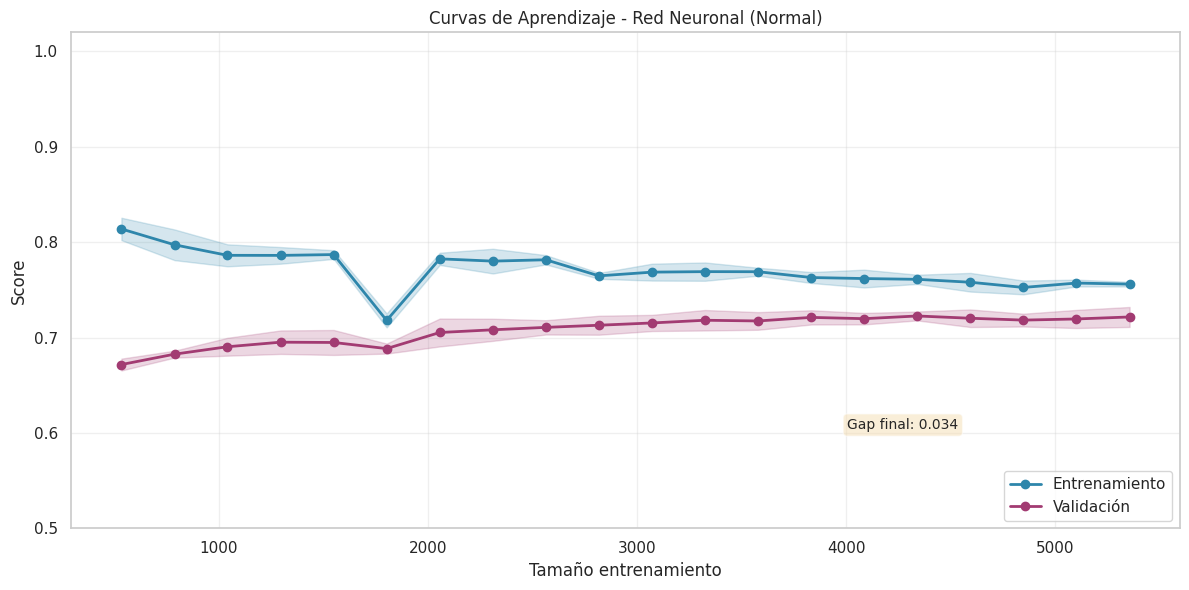

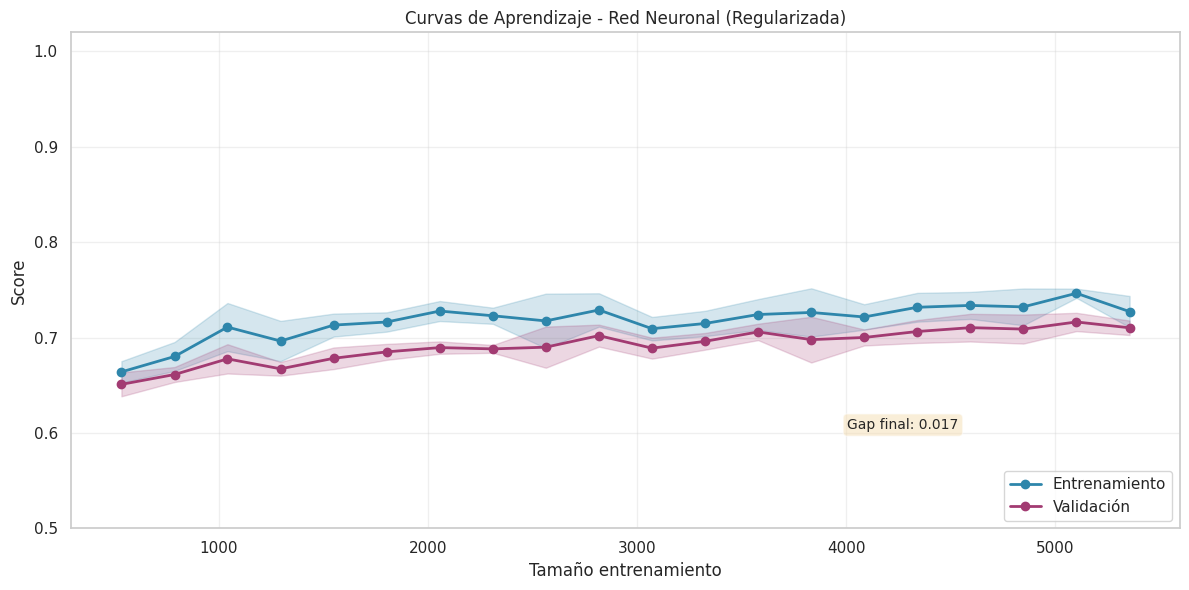


CONCLUSIONES
MEJOR MODELO: Red Neuronal (Normal)
Accuracy: 0.7348
F1-Score: 0.7163


In [2]:
"""
=============================================================================
ANÁLISIS DE EXOPLANETAS KEPLER CON MACHINE LEARNING (Redes Neuronales con SHAP)
Adaptación: Redes Neuronales (normal / regularizada) + SHAP
Ruta de datos: /content/cumulative.csv
=============================================================================
"""

# 0. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================
print("=" * 80)
print("INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER (Redes Neuronales con SHAP)")
print("=" * 80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import time

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.neural_network import MLPClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# Interpretabilidad
import shap

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10
print("Librerías cargadas exitosamente.")

# =============================================================================
# 1. FUNCIONES AUXILIARES
# =============================================================================
def print_section(title):
    print(f"\n{'='*80}")
    print(f"{title}")
    print('='*80)

def analyze_class_distribution(y, title="Distribución de Clases"):
    class_counts = y.value_counts()
    class_percentages = y.value_counts(normalize=True) * 100
    print(f"\n{title}:")
    print("-" * 50)
    for class_name, count, percentage in zip(class_counts.index, class_counts.values, class_percentages.values):
        label = {0: 'FALSE POSITIVE', 1: 'CONFIRMED', 2: 'CANDIDATE'}.get(class_name, str(class_name))
        print(f"{label}: {count:,} ({percentage:.2f}%)")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    ax1.bar(range(len(class_counts)), class_counts.values, color=colors[:len(class_counts)])
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE'][:len(class_counts)])
    ax1.set_ylabel('Cantidad')
    ax1.set_title('Distribución de Clases - Conteo')
    ax2.pie(class_counts.values, labels=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE'][:len(class_counts)],
            autopct='%1.1f%%', colors=colors[:len(class_counts)], startangle=90)
    ax2.set_title('Distribución de Clases - Porcentaje')
    plt.tight_layout()
    plt.show()
    return class_counts

def plot_learning_curves(model, X, y, cv=5, title="Curvas de Aprendizaje"):
    train_sizes = np.linspace(0.1, 1.0, 20)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='accuracy', shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', label='Entrenamiento', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2E86AB')
    plt.plot(train_sizes, val_mean, 'o-', color='#A23B72', label='Validación', linewidth=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#A23B72')
    gap = train_mean[-1] - val_mean[-1]
    plt.text(0.7, 0.2, f'Gap final: {gap:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.xlabel('Tamaño entrenamiento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 1.02)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 2. CARGA Y EXPLORACIÓN DE DATOS
# =============================================================================
print_section("CARGA Y EXPLORACIÓN DE DATOS")

df = pd.read_csv("/content/cumulative.csv")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

# =============================================================================
# 3. LIMPIEZA Y PREPARACIÓN DE DATOS
# =============================================================================
print_section("LIMPIEZA Y PREPARACIÓN DE DATOS")

cols_to_drop = [
    'rowid','kepid','kepoi_name','kepler_name','koi_pdisposition',
    'koi_tce_delivname','koi_score','koi_fpflag_nt','koi_fpflag_ss',
    'koi_fpflag_co','koi_fpflag_ec','koi_model_snr','koi_tce_plnt_num'
]

df_cleaned = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df_cleaned = df_cleaned.dropna(subset=['koi_disposition'])
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

mapping = {'CONFIRMED':1,'FALSE POSITIVE':0,'CANDIDATE':2}
df_cleaned['koi_disposition'] = df_cleaned['koi_disposition'].map(mapping)

X = df_cleaned.drop('koi_disposition', axis=1).select_dtypes(include=np.number)
y = df_cleaned['koi_disposition']

print(f"Dataset final: {X.shape[1]} características, {X.shape[0]:,} muestras")
analyze_class_distribution(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.3,random_state=42,stratify=y
)

# =============================================================================
# 4. PIPELINE DE PREPROCESAMIENTO
# =============================================================================
print_section("PIPELINE DE PREPROCESAMIENTO")

k_features = max(15, min(int(0.5 * X_train.shape[1]), 100))

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', SelectKBest(mutual_info_classif, k=k_features)),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed  = preprocessing_pipeline.transform(X_test)

selected_mask = preprocessing_pipeline.named_steps['selector'].get_support()
selected_features = [f for f, keep in zip(X_train.columns, selected_mask) if keep]
print("Características seleccionadas:", selected_features[:10], "...")

# =============================================================================
# 5. MODELOS (SOLO REDES NEURONALES)
# =============================================================================
print_section("DEFINICIÓN DE MODELOS - REDES NEURONALES")

models = {
    "Red Neuronal (Normal)": MLPClassifier(hidden_layer_sizes=(100,),
                                           activation='relu',
                                           alpha=1e-3,
                                           max_iter=600,
                                           random_state=42),
    "Red Neuronal (Regularizada)": MLPClassifier(hidden_layer_sizes=(80,40),
                                                 activation='relu',
                                                 alpha=5e-4,
                                                 max_iter=1000,
                                                 early_stopping=True,
                                                 validation_fraction=0.15,
                                                 n_iter_no_change=20,
                                                 random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================================================================
# 6. EVALUACIÓN COMPARATIVA
# =============================================================================
print_section("EVALUACIÓN COMPARATIVA - REDES NEURONALES")

results = []
detailed_results = {}

for name, model in models.items():
    print(f"\nEntrenando: {name}")
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='accuracy')
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    results.append({
        "Modelo": name,
        "CV Accuracy": cv_scores.mean(),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    })
    detailed_results[name] = {"model": model, "y_pred": y_pred}

results_df = pd.DataFrame(results)
print("\nResultados comparativos:")
print(results_df.to_string(index=False, float_format='%.4f'))

# =============================================================================
# 7. SHAP PARA NN
# =============================================================================
print_section("INTERPRETABILIDAD CON SHAP - MEJOR RED NEURONAL")

best_nn_name = max(detailed_results, key=lambda x: accuracy_score(y_test, detailed_results[x]["y_pred"]))
best_nn = detailed_results[best_nn_name]["model"]

bg = X_train_processed[np.random.choice(X_train_processed.shape[0], 100, replace=False)]
f_nn = lambda x: best_nn.predict_proba(x)
explainer = shap.KernelExplainer(f_nn, bg)
subset = X_test_processed[:200]
shap_values = explainer.shap_values(subset, nsamples="auto")
shap.summary_plot(shap_values, subset, feature_names=selected_features)

# =============================================================================
# 8. MATRICES DE CONFUSIÓN
# =============================================================================
print_section("MATRICES DE CONFUSIÓN - REDES NEURONALES")

fig, axes = plt.subplots(1, len(detailed_results), figsize=(10 * len(detailed_results), 6))
if len(detailed_results) == 1:
    axes = [axes]

for idx, (name, info) in enumerate(detailed_results.items()):
    cm = confusion_matrix(y_test, info["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FP', 'CONF', 'CAND'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(name)
plt.tight_layout()
plt.show()

# =============================================================================
# 9. CURVAS DE APRENDIZAJE
# =============================================================================
print_section("CURVAS DE APRENDIZAJE - REDES NEURONALES")

for name, info in detailed_results.items():
    plot_learning_curves(info["model"], X_train_processed, y_train, title=f"Curvas de Aprendizaje - {name}")

# =============================================================================
# 10. CONCLUSIONES
# =============================================================================
print_section("CONCLUSIONES")

best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"MEJOR MODELO: {best_model['Modelo']}")
print(f"Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
